---
sidebar_position: 3
keywords: [summarize, summarization, refine]
---

# How to summarize text through iterative refinement

LLMs can summarize and otherwise distill desired information from text, including large volumes of text. In many cases, especially when the amount of text is large compared to the size of the model's context window, it can be helpful (or necessary) to break up the summarization task into smaller components.

Iterative refinement represents one strategy for summarizing long texts. The strategy is as follows:

- Split a text into smaller documents;
- Summarize the first document;
- Refine or update the result based on the next document;
- Repeat through the sequence of documents until finished.

Note that this strategy is not parallelized. It is especially effective when understanding of a sub-document depends on prior context-- for instance, when summarizing a novel or body of text with an inherent sequence.

[LangGraph](https://langchain-ai.github.io/langgraph/), built on top of `langchain-core`, is well-suited to this problem:

- LangGraph allows for individual steps (such as successive summarizations) to be streamed, allowing for greater control of execution;
- LangGraph's [checkpointing](https://langchain-ai.github.io/langgraph/how-tos/persistence/) supports error recovery, extending with human-in-the-loop workflows, and easier incorporation into conversational applications.
- Because it is assembled from modular components, it is also simple to extend or modify (e.g., to incorporate [tool calling](/docs/concepts/tool_calling) or other behavior).

Below, we demonstrate how to summarize text via iterative refinement.

## Load chat model

Let's first load a chat model:

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs
  customVarName="llm"
/>


In [1]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Load documents

Next, we need some documents to summarize. Below, we generate some toy documents for illustrative purposes. See the document loader [how-to guides](/docs/how_to/#document-loaders) and [integration pages](/docs/integrations/document_loaders/) for additional sources of data. The [summarization tutorial](/docs/tutorials/summarization) also includes an example summarizing a blog post.

In [2]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

## Create graph

Below we show a LangGraph implementation of this process:

- We generate a simple chain for the initial summary that plucks out the first document, formats it into a prompt and runs inference with our LLM.
- We generate a second `refine_summary_chain` that operates on each successive document, refining the initial summary.

We will need to install `langgraph`:

In [3]:
pip install -qU langgraph

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gpt-researcher 0.8.0 requires langchain<0.3,>=0.2, but you have langchain 0.3.1 which is incompatible.
gpt-researcher 0.8.0 requires langchain-anthropic<0.2,>=0.1, but you have langchain-anthropic 0.2.1 which is incompatible.
gpt-researcher 0.8.0 requires langchain-community<0.3,>=0.2, but you have langchain-community 0.3.1 which is incompatible.
gpt-researcher 0.8.0 requires langchain-huggingface<0.1,>=0.0.1, but you have langchain-huggingface 0.1.0 which is incompatible.
gpt-researcher 0.8.0 requires langchain-openai<0.2,>=0.1, but you have langchain-openai 0.2.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

LangGraph allows the graph structure to be plotted to help visualize its function:

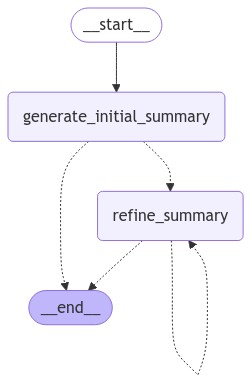

In [5]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

## Invoke graph

We can step through the execution as follows, printing out the summary as it is refined:

In [6]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)

Apples are typically red in color.
Apples are typically red in color, while blueberries are blue.
Apples are typically red in color, blueberries are blue, and bananas are yellow.


The final `step` contains the summary as synthesized from the entire set of documents.

## Next steps

Check out the summarization [how-to guides](/docs/how_to/#summarization) for additional summarization strategies, including those designed for larger volumes of text.

See [this tutorial](/docs/tutorials/summarization) for more detail on summarization.

See also the [LangGraph documentation](https://langchain-ai.github.io/langgraph/) for detail on building with LangGraph.